## Set Up Environment

In [2]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np

import joblib

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

# Specific settings to enhance visualization in Jupyter notebooks
pd.set_option('display.max_rows', 50)  # Limit the maximum number of visible rows to improve performance.
pd.set_option('display.max_columns', None)  # Show all available columns

# System settings and handling of custom modules
import sys
sys.path.append('..')

# Import custom modules for specific functionalities
from utils.utils import (
    clean_column_names,
    evaluate_model,
    evaluate_and_plot_model,
    plot_confusion_matrix_with_metrics,
    plot_feature_importances_bagging,
    plot_auc_roc
)

## Load Data

In [4]:
X_train = joblib.load('../../data/X_train.pkl')
X_test = joblib.load('../../data/X_test.pkl')
y_train = joblib.load('../../data/y_train.pkl')
y_test = joblib.load('../../data/y_test.pkl')

# Check the dimensions
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (136, 68) y_train: (136,)
X_test: (34, 68) y_test: (34,)


## Standard Scaler

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Correlation between variables

In [8]:
X_train_with_target = X_train.copy()
X_train_with_target['Target'] = y_train
corr_matrix = X_train_with_target.corr()

threshold = 0.5 # Correlation threshold

# Find pairs with correlation above the threshold
strong_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strong_pairs = strong_pairs.stack().reset_index()
strong_pairs.columns = ['variable1', 'variable2', 'correlation']

strong_pairs = strong_pairs[strong_pairs['correlation'] > threshold]  # Filter pairs with strong correlation.
strong_pairs = strong_pairs.sort_values('correlation', ascending=False) # Sort by correlation
strong_pairs

,variable1,variable2,correlation
2173,2heel raise,heel raise,1.000000
339,pace,step length,0.946542
325,pace,velocidad,0.895148
260,peso,imc,0.874890
134,altura,num calzado,0.837741
400,velocidad,step length,0.813111
567,shock,impact gs,0.804597
198,peso,num calzado,0.788302
69,sexo,num calzado,0.781624
568,shock,braking gs,0.765719


## Bagging Classifier

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=2; total time=   0.3s
[CV] END .............................estimato

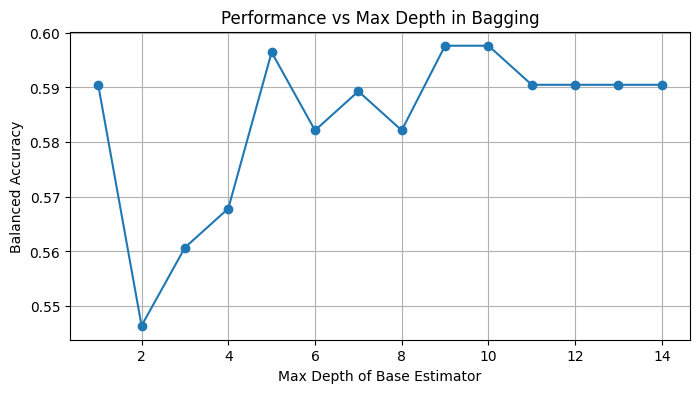

In [10]:
# Configure the RandomForestClassifier as the base estimator
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Set up the BaggingClassifier using RandomForest as the estimator
bagging_model = BaggingClassifier(
    estimator=rf_classifier,
    n_estimators=10,
    random_state=42
)

# Configuration for GridSearchCV
# Create a GridSearchCV to optimize max_depth of the RandomForest
param_grid_bagging = {'estimator__max_depth': range(1, 15)}
grid_bagging = GridSearchCV(bagging_model, param_grid=param_grid_bagging, scoring='balanced_accuracy', cv=10, verbose=2)
grid_bagging.fit(X_train, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_bagging.best_score_))
print("Best parameters: {}".format(grid_bagging.best_params_))

# Extraction of results for visualization
scores = grid_bagging.cv_results_['mean_test_score']
max_depths = range(1, 15)

# Graph of the results
plt.figure(figsize=(8, 4))
plt.plot(max_depths, scores, '-o')
plt.xlabel('Max Depth of Base Estimator')
plt.ylabel('Balanced Accuracy')
plt.title('Performance vs Max Depth in Bagging')
plt.grid(True)
plt.show()

In [11]:
best_bagging_model = grid_bagging.best_estimator_

print("Test Accuracy: {:.3f}".format(best_bagging_model.score(X_test, y_test)))
print("Train: ",best_bagging_model .score(X_train,y_train))
print("Test: ",best_bagging_model .score(X_test,y_test))

Test Accuracy: 0.676
Train:  0.9705882352941176
Test:  0.6764705882352942


Resultados para BaggingClassifier:
Accuracy: 0.6765
Precision: 0.6771
Recall: 0.6765
F1 Score: 0.6762


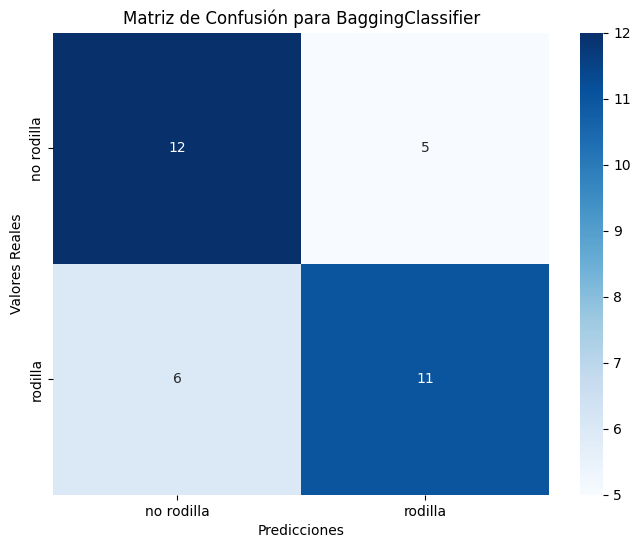

In [12]:
class_names = ['no rodilla', 'rodilla']
evaluate_model(best_bagging_model, X_test, y_test, class_names)

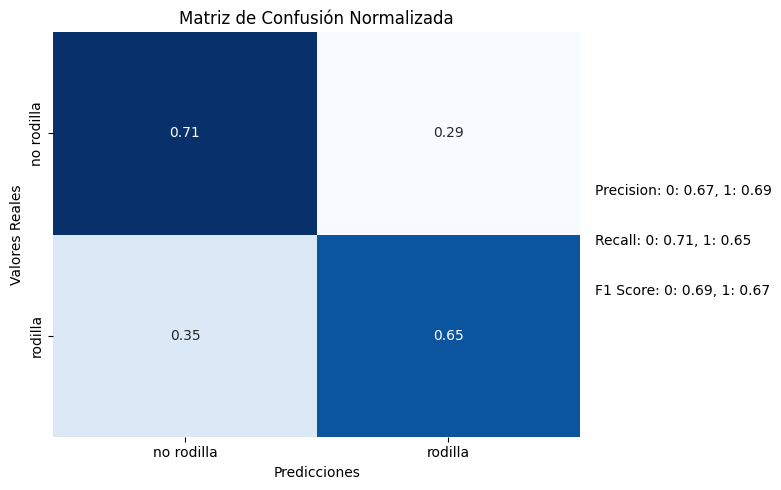


Classification Report:

              precision    recall  f1-score   support

  no rodilla       0.67      0.71      0.69        17
     rodilla       0.69      0.65      0.67        17

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.68        34
weighted avg       0.68      0.68      0.68        34



In [13]:
y_pred = best_bagging_model.predict(X_test)  # Etiquetas predichas por el modeloModel
plot_confusion_matrix_with_metrics(y_test, y_pred, class_names)

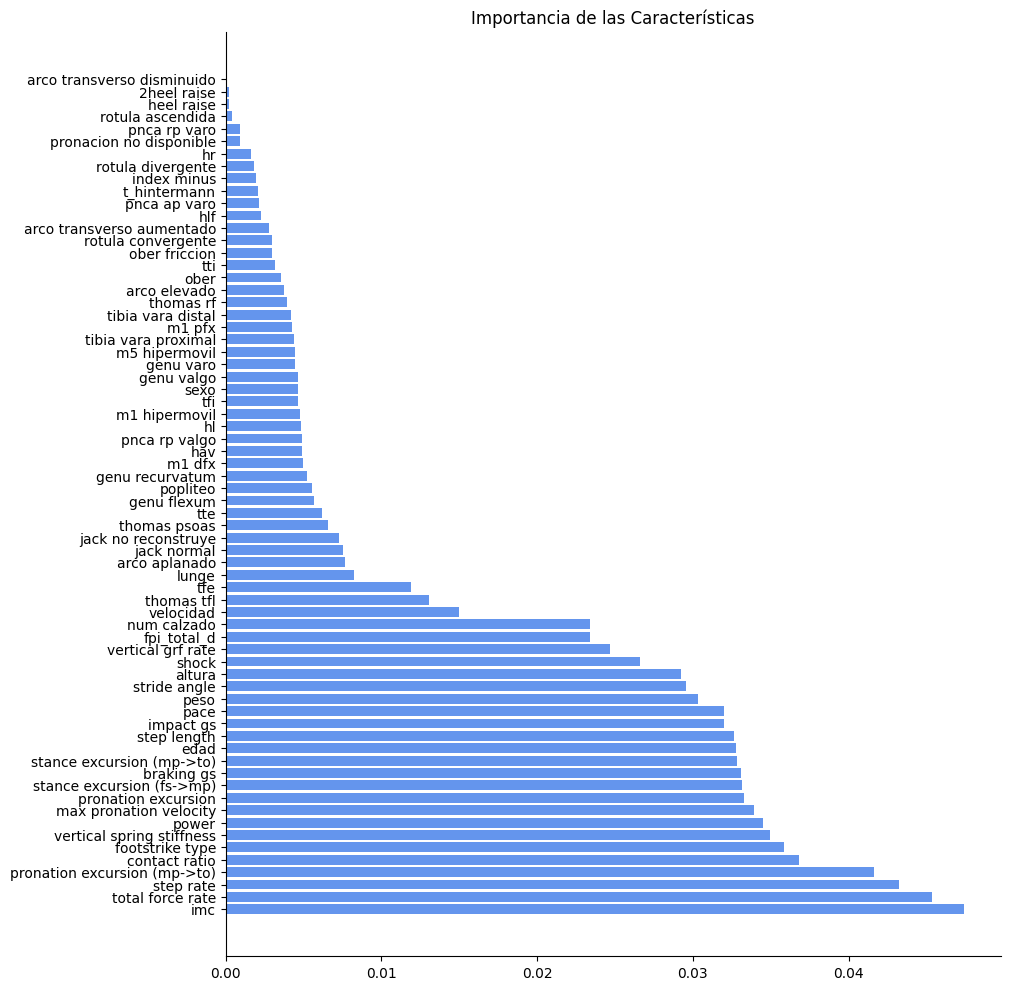

In [14]:
features_importances = plot_feature_importances_bagging(best_bagging_model, X_train.columns)

In [15]:
features_importances[0:45]

['imc',
 'total force rate',
 'step rate',
 'pronation excursion (mp->to)',
 'contact ratio',
 'footstrike type',
 'vertical spring stiffness',
 'power',
 'max pronation velocity',
 'pronation excursion',
 'stance excursion (fs->mp)',
 'braking gs',
 'stance excursion (mp->to)',
 'edad',
 'step length',
 'impact gs',
 'pace',
 'peso',
 'stride angle',
 'altura',
 'shock',
 'vertical grf rate',
 'fpi_total_d',
 'num calzado',
 'velocidad',
 'thomas tfl',
 'tfe',
 'lunge',
 'arco aplanado',
 'jack normal',
 'jack no reconstruye',
 'thomas psoas',
 'tte',
 'genu flexum',
 'popliteo',
 'genu recurvatum',
 'm1 dfx',
 'hav',
 'pnca rp valgo',
 'hl',
 'm1 hipermovil',
 'tfi',
 'sexo',
 'genu valgo',
 'genu varo']

### Feature Selection

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=2; total time=   0.3s
[CV] END .............................estimato

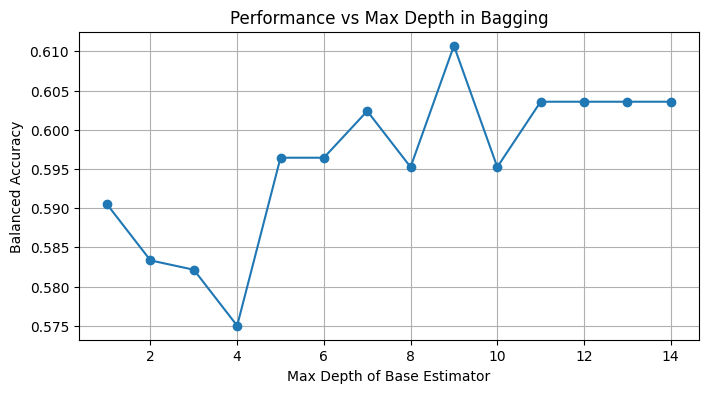

In [17]:
columns = features_importances[0:45]

# Configure the RandomForestClassifier as the base estimator
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Set up the BaggingClassifier using RandomForest as the estimator
bagging_model2 = BaggingClassifier(
    estimator=rf_classifier,
    n_estimators=10,
    random_state=42
)

param_grid_bagging = {'estimator__max_depth': range(1, 15)}
grid_bagging2 = GridSearchCV(bagging_model2, param_grid=param_grid_bagging, scoring='balanced_accuracy', cv=10, verbose=2)
grid_bagging2.fit(X_train[columns], y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_bagging2.best_score_))
print("Best parameters: {}".format(grid_bagging2.best_params_))

scores = grid_bagging2.cv_results_['mean_test_score']
max_depths = range(1, 15)

plt.figure(figsize=(8, 4))
plt.plot(max_depths, scores, '-o')
plt.xlabel('Max Depth of Base Estimator')
plt.ylabel('Balanced Accuracy')
plt.title('Performance vs Max Depth in Bagging')
plt.grid(True)
plt.show()

In [18]:
best_bagging_model2 = grid_bagging2.best_estimator_
print("Train: ",round(best_bagging_model2 .score(X_train[columns],y_train), 4))
print("Test: ",round(best_bagging_model2 .score(X_test[columns],y_test), 4))

Train:  0.9706
Test:  0.7353


Resultados para BaggingClassifier:
Accuracy: 0.7353
Precision: 0.7361
Recall: 0.7353
F1 Score: 0.7351


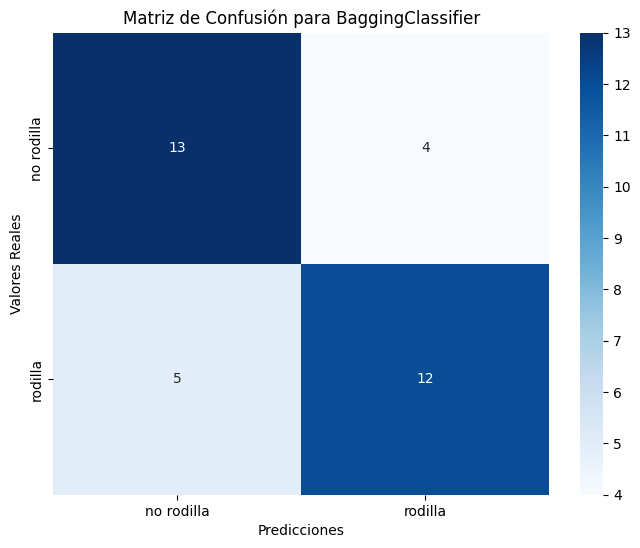

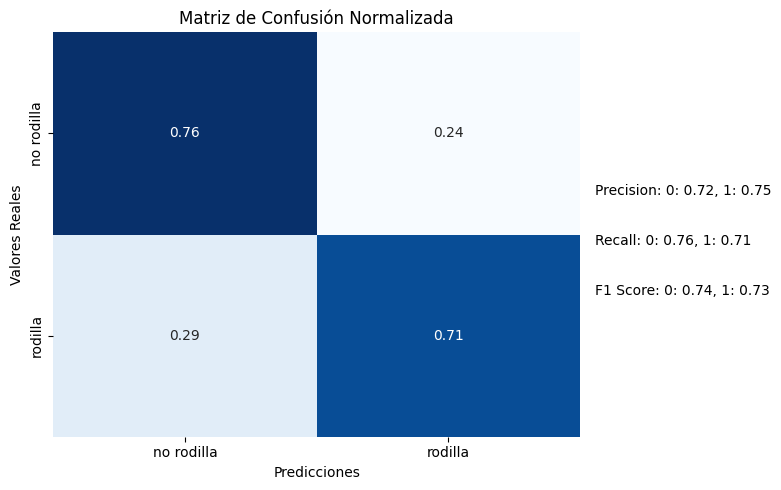


Classification Report:

              precision    recall  f1-score   support

  no rodilla       0.72      0.76      0.74        17
     rodilla       0.75      0.71      0.73        17

    accuracy                           0.74        34
   macro avg       0.74      0.74      0.74        34
weighted avg       0.74      0.74      0.74        34



In [19]:
evaluate_and_plot_model(best_bagging_model2, X_test[columns], y_test, class_names)

AUC-ROC: 0.7266


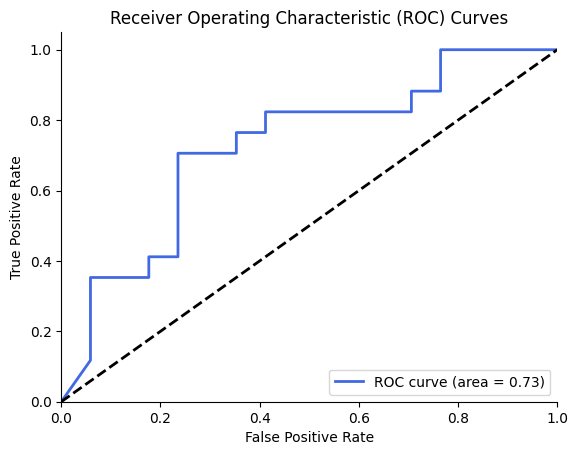

In [20]:
plot_auc_roc(best_bagging_model2, X_test[columns], y_test, class_names)

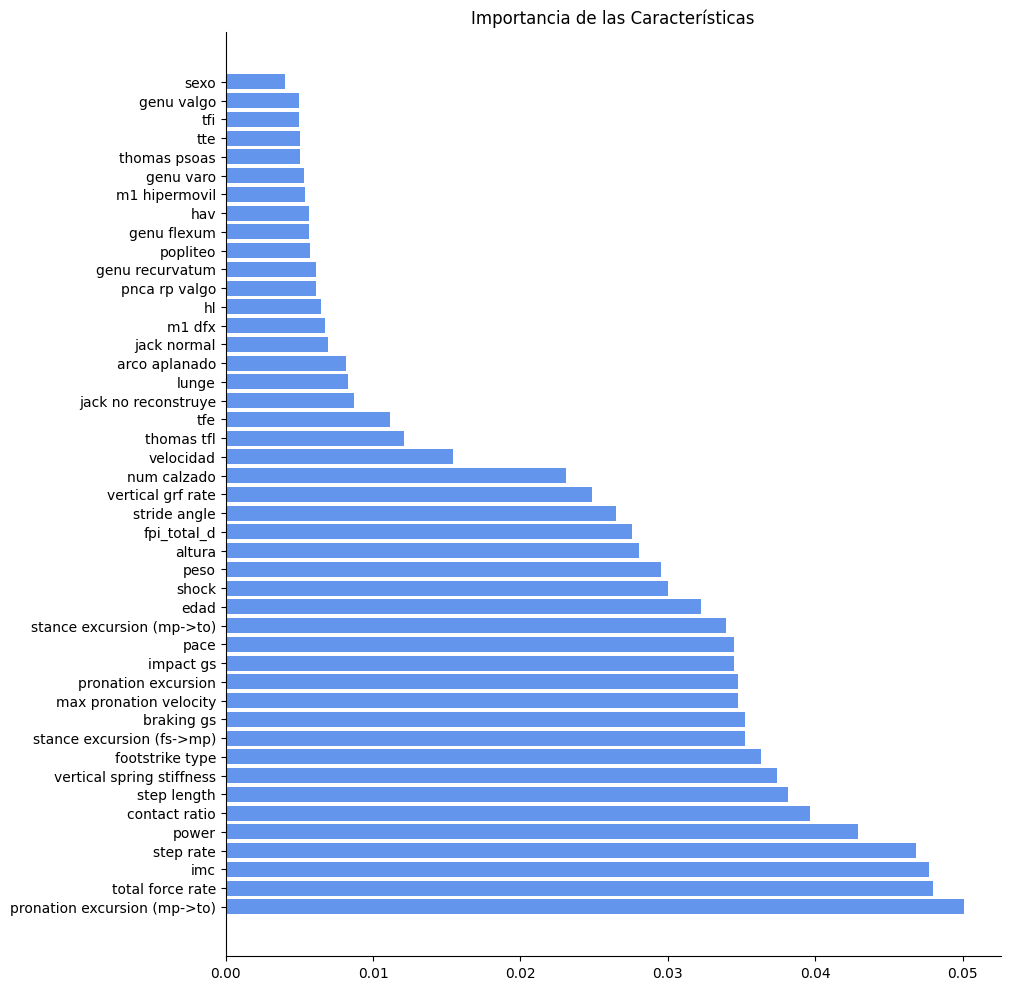

In [21]:
features_importances2 = plot_feature_importances_bagging(best_bagging_model2, columns)

In [22]:
# Save the trained model
model_filename = '../../src/models/bagging_classifier_model.pkl'
joblib.dump(best_bagging_model2, model_filename)

print(f"Model saved as {model_filename}")

Model saved as bagging_classifier_model.pkl
